# Project Psyched: A Closer Look Into Reproducibility In Psychological Research

## Data Analysis & Visualization Script: Part 2 - Test Statistics & Recalcuating P-Values
This script for data analysis and visualization after data has been scraped from TDM Studio.

Author: Yuyang Zhong (2020). This work is licensed under a [Creative Commons BY-NC-SA 4.0 International
License][cc-by].

![CC BY-NC-SA 4.0][cc-by-shield]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-shield]: https://img.shields.io/badge/license-CC--BY--NC--SA%204.0-blue

#### Setup & Imports

In [1]:
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

from scipy import stats

In [2]:
in_path = "../data/"
in_name = 'JPSP_part2_092020.csv'

In [3]:
df = pd.read_csv(in_path + in_name, index_col=0)

#### Helper functions

In [4]:
def extract_f(s):
    """
    Takes in a string of reported F statistics with p-value and extract the numeric parameters.
    
    Returns: df1, df2, x, p
    """
    extract = re.findall(
        r'Fs?\s*\(\s*(\d+)\s*\,\s*(\d+)\s*\)\s*[\<|\>|\=]\s*(\d*\.?\d*)\s*\,\s*p\s*[\<|\>|\=]\s*(\d*\.\d+)',
        s)[0]    
    
    df1 = float(extract[0])
    df2 = float(extract[1])
    x = float(extract[2])
    p = float(extract[3])
    
    return df1, df2, x, p

In [5]:
def extract_f_ns(s):
    """
    Takes in a string of reported F statistics, non-significant, and extract the numeric parameters.
    
    Returns: df1, df2, x
    """
    extract = re.findall(
        r'Fs?\s*\(\s*(\d+)\s*\,\s*(\d+)\s*\)\s*[\<|\>|\=]\s*(\d*\.?\d*)\s*\,\s*n\.?s\.?',
        s)[0] 

    df1 = float(extract[0])
    df2 = float(extract[1])
    x = float(extract[2])
    
    return df1, df2, x

In [6]:
def extract_t(s):
    """
    Takes in a string of reported t score with p-value and extract the numeric parameters.
    
    Returns: df, x, p
    """
    
    s = re.sub(r'−\s*', "-", s)
    extract = re.findall(
        r't\s*\((\s*\d*\s*,)?\s*(\d+)\s*\)\s*[\<|\>|\=]\s*([\−|\-]?\s*\d*\.?\d*)\s*,\s*p\s*[\<|\>|\=]\s*(\d?\.\d+)',
        s)[0]
    
    df = float(extract[1])
    x = float(extract[2].replace(" ", ""))
    p = float(extract[3])
    
    return df, x, p

In [7]:
def extract_t_ns(s):
    """
    Takes in a string of reported t score, non-significant, and extract the numeric parameters.
    
    Returns: df, x
    """
    
    s = re.sub(r'−\s*', "-", s)
    extract = re.findall(
        r't\s*\((\s*\d*\s*,)?\s*(\d+)\s*\)\s*[\<|\>|\=]\s*([\−|\-]?\s*\d*\.?\d*)\s*,\s*p\s*[\<|\>|\=]\s*(\d?\.\d+)',
        s)[0]  
    
    df = float(extract[1])
    x = float(extract[2].replace(" ", ""))
    
    return df, x

#### Set up output dataframe

In [8]:
df_stats = pd.DataFrame(columns=['File', 'Original', 'Type', 'Reported p-value', 'Recalculated p-value'])
# df_stats_ns = pd.DataFrame(columns=['File', 'Original', 'Type', 'Reported p-value', 'Recalculated p-value'])

#### Script to iterate through all statistics

In [9]:
def extract_f_compute_add(test_type, index, s, df_stats=df_stats):
    ex = extract_f(s)
    return {'File': index, 
            'Original': s, 
            'Type': test_type, 
            'Reported p-value': ex[3], 
            'Recalculated p-value': 1-stats.f.cdf(ex[2], ex[0], ex[1])}

In [10]:
def extract_t_compute_add(test_type, index, s, df_stats=df_stats):
    ex = extract_t(s)
    return {'File': index, 
            'Original': s, 
            'Type': test_type, 
            'Reported p-value': ex[2], 
            'Recalculated p-value': 1-stats.t.cdf(ex[1], ex[0])}

In [11]:
# for s in df.loc['614337945.xml'].apply(ast.literal_eval)['t_scores']:
#     df_stats = df_stats.append(extract_t_compute_add('t', '614337945.xml', s), ignore_index=True)

# for s in df.iloc[2].apply(ast.literal_eval)['F_stats']:
#     df_stats = df_stats.append(extract_f_compute_add('f', '0.xml', s), ignore_index=True)

In [12]:
for index, row in df.iterrows():
    r = row.apply(ast.literal_eval)
    
    if len(r['F_stats']) > 0:
        for s in r['F_stats']:
            df_stats = df_stats.append(extract_f_compute_add('f', index, s), ignore_index=True)
            
    if len(r['t_scores']) > 0:
        for s in r['t_scores']:
            df_stats = df_stats.append(extract_t_compute_add('t', index, s), ignore_index=True)

In [13]:
df_stats

,File,Original,Type,Reported p-value,Recalculated p-value
0,614337945.xml,"t (41) = 4.10, p < .01",t,0.01,9.531027e-05
1,614337945.xml,"t (41) = −3.56, p < .01",t,0.01,9.995224e-01
2,614337945.xml,"t (41) = 8.21, p < .01",t,0.01,1.708961e-10
3,614337945.xml,"t (41) = 4.82, p < .01",t,0.01,9.987600e-06
4,614337945.xml,"t (41) = −2.57, p < .01",t,0.01,9.930493e-01
...,...,...,...,...,...
98883,614461090.xml,"t(72) = 1.89, p < .07",t,0.07,3.139171e-02
98884,614461090.xml,"t(72) = 1.63, p < .11",t,0.11,5.373448e-02
98885,614461090.xml,"t(81) = 1.79, p < .08",t,0.08,3.859545e-02
98886,614461090.xml,"t(81) = 1.72, p < .08",t,0.08,4.462558e-02


In [14]:
df_stats[df_stats['Recalculated p-value'] > 1].head()

,File,Original,Type,Reported p-value,Recalculated p-value


In [15]:
df_stats[df_stats['Reported p-value'] > 1].head()

,File,Original,Type,Reported p-value,Recalculated p-value
30638,745195391.xml,"t(200) = 12.14, p < 2.2",t,2.200,0.000000e+00
30639,745195391.xml,"t(201) = 12.12, p < 2.2",t,2.200,0.000000e+00
30640,745195391.xml,"t(202) = 6.73, p = 1.695",t,1.695,8.577694e-11
30641,745195391.xml,"t(199) = 12.56, p < 2.2",t,2.200,0.000000e+00
30642,745195391.xml,"t(200) = 4.92, p = 1.77",t,1.770,9.019072e-07


/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


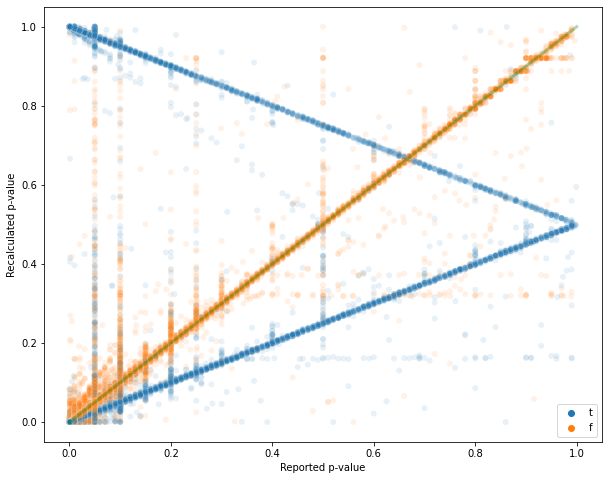

In [16]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats[(df_stats['Reported p-value'] < 1) & (df_stats['Recalculated p-value'] < 1)], 
                alpha=0.1, hue='Type')
sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

#### Debugging curves

In [17]:
# debug1 = df_stats[(df_stats['Reported p-value'] == 0.5) 
#                  & (df_stats['Recalculated p-value'] > 0.28)
#                  & (df_stats['Recalculated p-value'] < 0.32)
#                  & (df_stats['Type']== 't')
#                  ]

# debug2 = df_stats[(df_stats['Reported p-value'] > 0.58) 
#                  & (df_stats['Reported p-value'] < 0.62)
#                  & (df_stats['Recalculated p-value'] > 0.36)
#                  & (df_stats['Recalculated p-value'] < 0.4)
#                  & (df_stats['Type']== 't')
#                  ]

# debug3 = df_stats[(df_stats['Reported p-value'] > 0.78) 
#                  & (df_stats['Reported p-value'] < 0.82)
#                  & (df_stats['Recalculated p-value'] > 0.78)
#                  & (df_stats['Recalculated p-value'] < 0.82)
#                  & (df_stats['Type']== 'f')
#                  ]

# debug4 = df_stats[(df_stats['Reported p-value'] > 0.38) 
#                  & (df_stats['Reported p-value'] < 0.42)
#                  & (df_stats['Recalculated p-value'] > 0.28)
#                  & (df_stats['Recalculated p-value'] < 0.32)
#                  & (df_stats['Type']== 'f')
#                  ]

In [19]:
# debug1.to_csv('debug1.csv')
# debug2.to_csv('debug2.csv')
# debug3.to_csv('debug3.csv')
# debug4.to_csv('debug4.csv')

In [20]:
df_stats_corrected = pd.DataFrame(columns=df_stats.columns)

for index, row in df_stats.iterrows():
    if row['Type'] == 't':
        if row['Recalculated p-value'] > 0.05:
            row['Recalculated p-value'] = 1 - row['Recalculated p-value']
        row['Recalculated p-value'] = row['Recalculated p-value'] * 2
    df_stats_corrected = df_stats_corrected.append(row)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


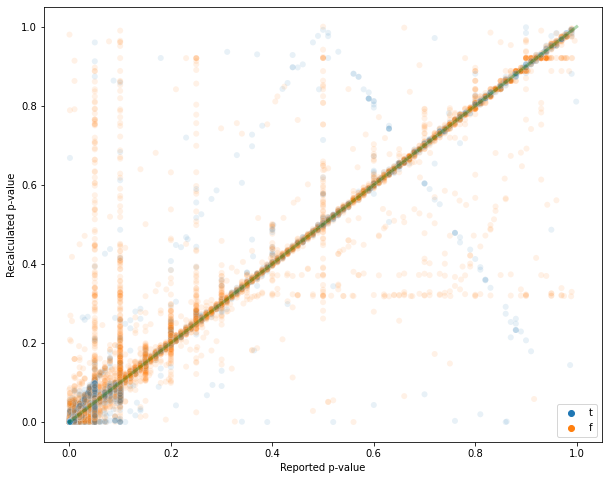

In [22]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats_corrected[(df_stats['Reported p-value'] < 1) & (df_stats_corrected['Recalculated p-value'] < 1)], 
                alpha=0.1, hue='Type')
sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

#### More Plots

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


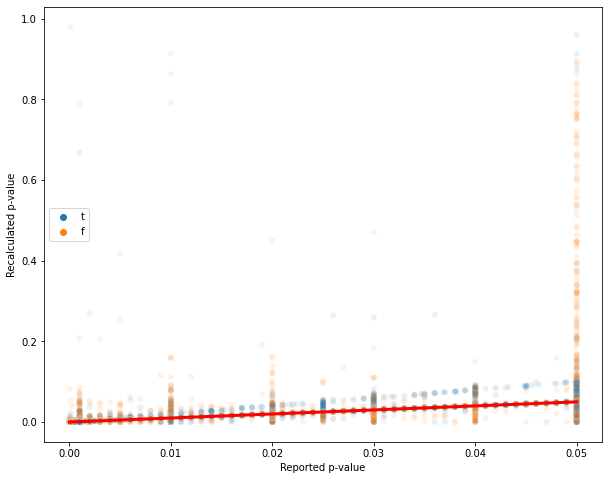

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats_corrected[(df_stats_corrected['Reported p-value'] <= 0.05) 
                                        & (df_stats_corrected['Recalculated p-value'] < 1)], 
                alpha=0.1, hue='Type')
sns.lineplot(np.linspace(0, 0.05, 100), np.linspace(0, 0.05, 100), color='red', linewidth=3, alpha=1);

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


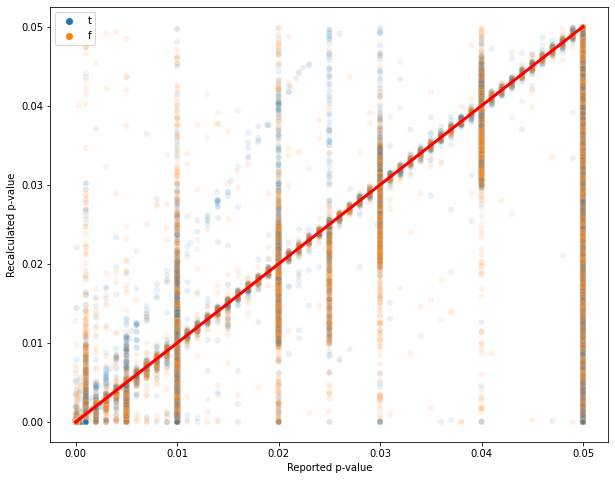

In [24]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats_corrected[(df_stats_corrected['Reported p-value'] <= 0.05) 
                                        & (df_stats_corrected['Recalculated p-value'] < 0.05)], 
                alpha=0.1, hue='Type')
sns.lineplot(np.linspace(0, 0.05, 100), np.linspace(0, 0.05, 100), color='red', linewidth=3, alpha=1);

<AxesSubplot:xlabel='Recalculated p-value', ylabel='Count'>

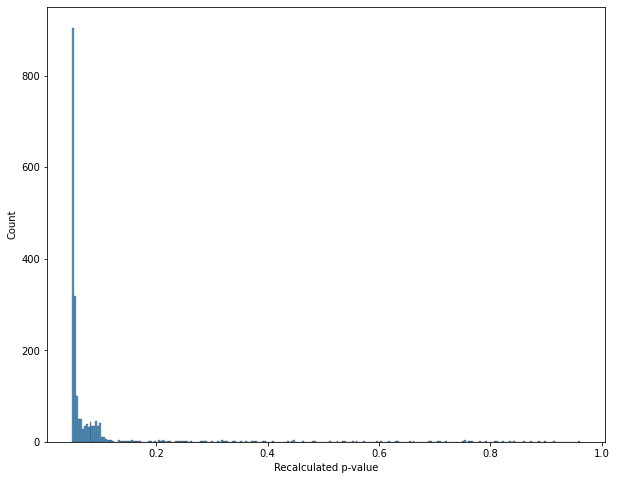

In [25]:
plt.figure(figsize=(10, 8))
sns.histplot(df_stats_corrected[(df_stats_corrected['Reported p-value'] == 0.05) 
                      & (df_stats_corrected['Recalculated p-value'] < 1) 
                                & (df_stats_corrected['Recalculated p-value'] > 0.05)]['Recalculated p-value'])